In [1]:
import numpy as np
import pylab as plt

import torch
import torch.nn as nn

from sklearn.datasets import make_circles
from sklearn.neighbors import KernelDensity

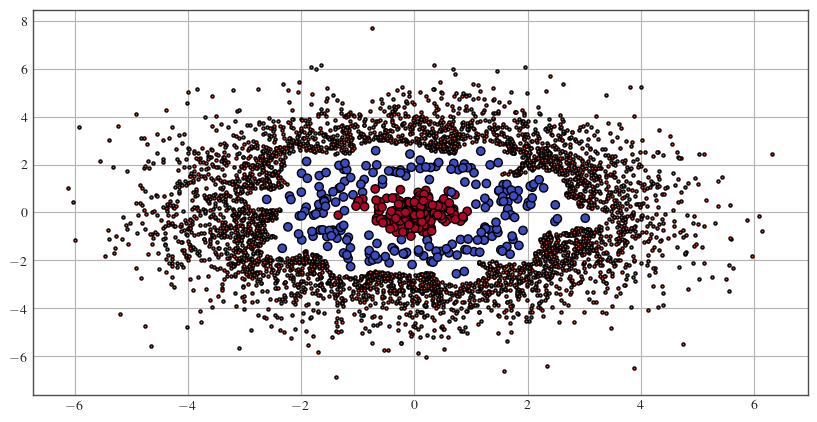

In [2]:
X, y = make_circles(n_samples=400, random_state=42, noise=.2, factor=1e-4)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long() %2
X = (X - X.mean(0)) / X.std(0)

train_ds = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)

kde = KernelDensity(bandwidth=.1).fit(X)
def gen_ood(X_batch, y_batch=None, boundary=1e-5, *args, **kwargs):
    device = X_batch.device
    n_samples = len(X_batch)
    ood_samples = []
    while len(ood_samples) < n_samples:
        outer = np.random.multivariate_normal(np.zeros(2), np.eye(2)*3, size=1000)
        ood_samples.extend(outer[kde.score_samples(outer) < np.log(boundary)])

    return torch.from_numpy(np.stack(ood_samples)).float()[:n_samples].to(device)


X_out = torch.cat([gen_ood(X) for _ in range(10)])
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=4)
plt.scatter(X_out[:, 0], X_out[:, 1], zorder=3, s=5)
plt.show()

In [6]:
from utils.xedl import xEDLWrapper
net_init = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 2))
net_init.n_classes = 2
net = xEDLWrapper(net=net_init, lmb=.05, ood_generator=gen_ood)
net.fit(
    train_loader,
    val_loader_in=train_loader,
    val_loader_out=train_loader,
    n_epochs=200,
    weight_decay=1e-3,
    verbose=0,
)

Training on cuda.


[Ep 199] Loss (In/Out) = 0.031/0.131 | Acc=0.993/0.993 | AUROC=0.500



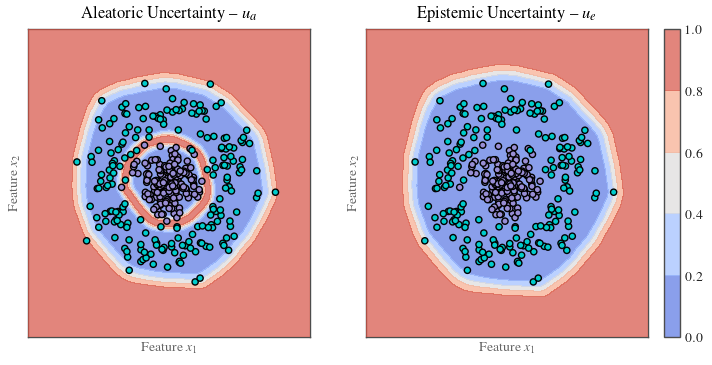

In [34]:
r, res = 4, .01
net.cpu()
xx, yy = np.mgrid[-r:r:res, -r:r:res]
zz = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('Aleatoric Uncertainty -- $u_a$')
with torch.no_grad():
    aleatoric_unc = net.predict_aleatoric(zz).view(xx.shape)
plt.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: 'C{}'.format(x),(y+3).tolist())), zorder=4, s=20)
c = plt.contourf(xx, yy, aleatoric_unc, levels=np.linspace(0, 1, 6), zorder=3, alpha=.7)
plt.xticks([])
plt.yticks([])
plt.xlabel('Feature $x_1$')
plt.ylabel('Feature $x_2$')

plt.subplot(122)
plt.title('Epistemic Uncertainty -- $u_e$')
with torch.no_grad():
    epistemic_unc = net.predict_epistemic(zz).view(xx.shape)
plt.scatter(X[:, 0], X[:, 1], c=list(map(lambda x: 'C{}'.format(x),(y+3).tolist())), zorder=4, s=20, )
c = plt.contourf(xx, yy, epistemic_unc, levels=np.linspace(0, 1, 6), zorder=3, alpha=.7)
plt.xlabel('Feature $x_1$')
plt.ylabel('Feature $x_2$')
plt.xticks([])
plt.yticks([])

fig = plt.gcf()
ax = plt.gca()
bbox_ax = ax.get_position()
cbar_im1a_ax = fig.add_axes([.92, bbox_ax.y0, 0.02, bbox_ax.y1-bbox_ax.y0])
cbar_im1a = plt.colorbar(c, cax=cbar_im1a_ax)
plt.savefig('./plots/circles.pdf')
plt.show()

['C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C1',
 'C1',
 'C0',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C1',
 'C0',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C1',
 'C1',
 'C1',
 'C0',
 'C1',
 'C1',
 'C0',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C1',
 'C1',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C0',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C1',
 'C1',
 'C1',
 'C0',
 'C0',
 'C1',
 'C1',
 'C1',
 'C0',
 'C0',
 'C0',
 'C1',
 'C0',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C1',
 'C0',
 'C1',
 'C0',
 'C0',
 'C0',
 'C1',
 'C1',
 'C1',
 'C1',
 'C0',
 'C0',
 'C1',